In [1]:
# Import libaries
import Analysis2 as ana
import LeadTime as LT
import HUXt as H
import os 

from astropy.time import Time, TimeDelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [12]:
# Run the lead time analysis. Create dataframe of the rolling RMSE for all ensemble members, then returns the lowest percent per binned data. 

tag="12Dec08_n=200_r=30_PS=1"
df30 = LT.loopLT(tag, feature="N&F", percent=25, lowestsubset=True, xaxis="time")

tag="12Dec08_n=200_r=8_PS=1"
df8 = LT.loopLT(tag, feature="N&F", percent=25, lowestsubset=True, xaxis="time")

tag="12Dec08_n=200_r=30_PS=1_HelioMAS"
df30MAS = LT.loopLT(tag, feature="N&F", percent=25, lowestsubset=True, xaxis="time")

# display(df30, df8)

Progress: 0 out of 42
No data valid for this timestep.
Progress: 1 out of 42
No data valid for this timestep.
Progress: 2 out of 42
No data valid for this timestep.
Progress: 3 out of 42
No data valid for this timestep.
Progress: 4 out of 42
No data valid for this timestep.
Progress: 5 out of 42
No data valid for this timestep.
Progress: 6 out of 42
The curve has fit f(x) = 0.008x^2 + 0.033x + 0.200.
The x solution is -2.144units ±0.633units with 68% CI or ±1.213units for 95% CI. Units are either hours for time for km/s for speed
At the curve minimum, the RMSE (i.e., the y value) is 0.165˚
Progress: 7 out of 42
The curve has fit f(x) = 0.003x^2 + 0.001x + 0.213.
The x solution is -0.192units ±0.421units with 68% CI or ±0.739units for 95% CI. Units are either hours for time for km/s for speed
At the curve minimum, the RMSE (i.e., the y value) is 0.213˚
Progress: 8 out of 42
The curve has fit f(x) = -0.000x^2 + -0.018x + 0.365.
The x solution is 14.631units ±5.127units with 68% CI or ±13

In [ ]:
display(df)

In [ ]:
tag="12Dec08_n=200_r=8_PS=1"
xaxis="time"
obsACE = Time('2008-12-16 07:00:00', format='iso').jd
feature = "N&F"
spacecraft = "STEREO"

# Create dataframe
ens_estimates = pd.DataFrame()

for index in range(43):
    df2 = LT.bindataLT(tag, index, feature="N&F", percent=25, lowestsubset=True)
    display(index)
    if df2 is not None:
        arrival_info, timeres_subset, histoinfo, lowestmembers = df2      
        lowestmembers = lowestmembers.dropna()
        
        if xaxis == "time":
            x1 = (arrival_info["Arrival Time"] - obsACE)*24
            y1 = (arrival_info["RMSE {} {}".format(feature, spacecraft)])

            xlow1 = (lowestmembers["Arrival Time"] - obsACE)*24
            ylow1 = (lowestmembers["RMSE {} {}".format(feature, spacecraft)])

            deter1 = arrival_info[arrival_info["file"] == "deterministic"]
            deterATE1 = (deter1["Arrival Time"][0] - obsACE)*24
        
        # Find quadratic curve of regression    
        popt, fx_df, x_solution = ana.quadraticcurvefit(xlow1, ylow1, timeres_subset, obsACE)
        xsol1, xuncert68, xuncert95 = x_solution
#         # define a sequence of inputs between the smallest and largest known inputs
#         fxX1 = np.arange(min(x1), max(x1)+1, 0.5)
#         # calculate the output for the range
#         a, b, c = popt
#         fxY1 = ana.objective(fxX1, a, b, c)

        # Store into dataframe
        ens_estimates = ens_estimates.append({"obs timestamp": index ,
                                              "ens estimate time": xsol1,
                                              "time uncertainty 1SD": xuncert68}, ignore_index=True)

display("end")

In [145]:
# Merge the two data frame on the observed arrival time.
dfmerge= pd.merge(df8, df30, how='outer', on=["obs timestamp"])
dfmerge2= pd.merge(dfmerge, df30MAS, how='outer', on=["obs timestamp"])

# Create data of the L1 arrival (datetime) for plotting. This is not the most effecient way as this should be done when making the dataframe. But this quick fix works fine.
obsarrivalestimate = Time('2008-12-16T07:00:00',format='isot').datetime
dfmerge2["L1 arrival 30"] = obsarrivalestimate + pd.to_timedelta(dfmerge2["ens estimate time_y"], 'h')
dfmerge2["L1 arrival 8"] = obsarrivalestimate + pd.to_timedelta(dfmerge2["ens estimate time_x"], 'h')
dfmerge2["L1 arrival 30MAS"] = obsarrivalestimate + pd.to_timedelta(dfmerge2["ens estimate time"], 'h')

dfmerge2["lead time (h)"] = (obsarrivalestimate - pd.to_datetime(dfmerge2["obs timestamp"]))/np.timedelta64(1, 'h')


dfmerge2[5:6]

,ens estimate time_x,obs timestamp,time uncertainty 1SD_x,ens estimate time_y,time uncertainty 1SD_y,timedelta (h),ens estimate time,time uncertainty 1SD,L1 arrival 30,L1 arrival 8,L1 arrival 30MAS,lead time (h)
5,4.338796,2008-12-12 19:29:36,0.83973,-2.143618,0.632976,2008-12-16 04:51:22.976769600,1.434552,2.852306,2008-12-16 04:51:22.976769600,2008-12-16 11:20:19.666680,2008-12-16 08:26:04.388845200,83.506667


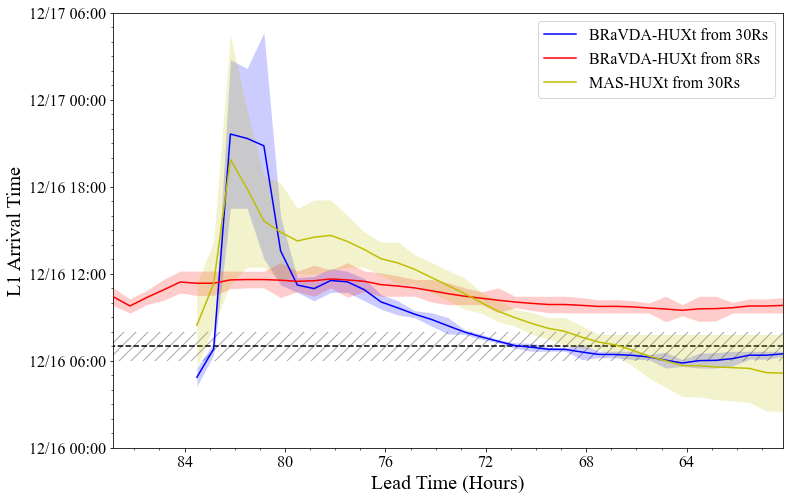

In [146]:
#Read in HI1 STEREO-B Time
# df_b = pd.read_csv(r"HCME_B__20081212_01_pa_slice_264_degrees.csv")
# df_b = df_b.drop(columns=['Unnamed: 0'])
# df_b['time'] = pd.to_datetime(df_b['time'])
# HItimeB = df_b['time'][df_b['front'] == "Draw INNER front"]
# timeB = Time(HItimeB).datetime

# # Obs
# obsTime = Time('2008-12-12T12:00:00',format='isot').datetime
# leadtime = obsTime - timeB
# print(type(timeB))

# Calculate leadtime for x-axis
obsTime = Time('2008-12-16T07:00:00',format='isot').datetime
HIobstime = pd.to_datetime(dfmerge2["obs timestamp"])
leadtime = (obsTime - HIobstime)

dfmerge2["leadtime (timedelta)"] = leadtime
dfmerge2["leadtime (hours)"] = leadtime/ np.timedelta64(1, 'h')

# Assign plotting variables 
x = dfmerge2["leadtime (hours)"]

            # THIS WORKS FOR PLOTTING THE ARRIVAL TIME ERROR AT L1
            # y30 = dfmerge2["ens estimate time_y"]
            # yerr30 =dfmerge2["time uncertainty 1SD_y"]

            # y8 = dfmerge2["ens estimate time_x"]
            # yerr8 = dfmerge2["time uncertainty 1SD_x"]

            # y30MAS = dfmerge2["ens estimate time"]
            # yerr30MAS = dfmerge2["time uncertainty 1SD"]

# THIS WORKS FOR PLOTTING THE ARRIVAL TIME AT L1 (datetime)
y30 = dfmerge2["L1 arrival 30"]
yerr30 = pd.to_timedelta(dfmerge2["time uncertainty 1SD_y"],'h')

y8 = dfmerge2["L1 arrival 8"]
yerr8 = pd.to_timedelta(dfmerge2["time uncertainty 1SD_x"],'h')

y30MAS = dfmerge2["L1 arrival 30MAS"]
yerr30MAS = pd.to_timedelta(dfmerge2["time uncertainty 1SD"],'h')






# Plot figure
plt.rcParams.update({'font.size': 16, 'axes.labelsize':20, 'legend.fontsize':16,'xtick.labelsize': 16.0,'ytick.labelsize': 16.0, "font.family":"Times New Roman"})

fig, ax = plt.subplots(1, 1, figsize = [12,8],sharex=False, sharey=False, constrained_layout=False)

ax.yaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
ax.yaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.yaxis.set_minor_locator(mdates.HourLocator(interval=1))

ax.xaxis.set_major_locator(MultipleLocator(4))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.set_xlabel("Lead Time (Hours)")
ax.set_ylabel("L1 Arrival Time")
ax.set_xlim(left=x.min(), right=x.max())
ax.set_ylim(bottom = Time('2008-12-16T00:00:00',format='isot').datetime,
           top = Time('2008-12-17T06:00:00',format='isot').datetime)

ax.hlines(obsTime, x.min(), x.max(), color='k', ls='--')
ax.fill_between(x, obsTime + timedelta(hours=1),obsTime + timedelta(hours=-1), facecolor='w', edgecolor='gray',hatch="//", alpha=0.7, zorder=1, lw=0)

ax.plot(x,y30, color='b', ls='-', lw=1.5, zorder=3, label="BRaVDA-HUXt from 30Rs")
ax.fill_between(x, y30 - yerr30, y30 + yerr30, color='b', alpha=0.2, zorder=3, lw=0)

plt.plot(x,y8, color='r', ls='-', lw=1.5, zorder=3, label="BRaVDA-HUXt from 8Rs")
plt.fill_between(x, y8 - yerr8, y8 + yerr8, color='r', alpha=0.2, zorder=3, lw=0)

plt.plot(x,y30MAS, color='y', ls='-', lw=1.5, zorder=3, label="MAS-HUXt from 30Rs")
plt.fill_between(x, y30MAS - yerr30MAS, y30MAS + yerr30MAS, color='y', alpha=0.2, zorder=3, lw=0)
# plt.text(82, 0.5,"07:00:00 12/16/2008")

# Invert x-axis so the lead time is in decending order
ax.invert_xaxis()

plt.legend()
project_dirs = H._setup_dirs_()
        
filename = "HUXt_leadtime.png"
filepath = os.path.join(project_dirs['HUXt_figures'], filename)            
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# filename = "HUXt_leadtime.pdf".format(tag)
# filepath = os.path.join(project_dirs['HUXt_figures'], filename)           
# plt.savefig(filepath, dpi=300, bbox_inches='tight')

In [93]:
obsTimeT = Time('2008-12-16T07:00:00',format='isot').datetime
df30['timedelta (h)'] = pd.to_timedelta(df30["ens estimate time"], 'h') + obsTimeT

df30

,ens estimate time,obs timestamp,time uncertainty 1SD,timedelta (h)
0,-2.143618,2008-12-12 19:29:36,0.632976,2008-12-16 04:51:22.976769600
1,-0.192200,2008-12-12 20:09:36,0.420809,2008-12-16 06:48:28.078578000
2,14.631158,2008-12-12 20:49:36,5.126549,2008-12-16 21:37:52.167100800
3,14.329221,2008-12-12 21:29:36,4.824613,2008-12-16 21:19:45.195258000
4,13.822275,2008-12-12 22:09:36,7.796166,2008-12-16 20:49:20.189416800
5,6.574520,2008-12-12 22:49:37,2.350338,2008-12-16 13:34:28.273303200
6,4.215138,2008-12-12 23:29:36,0.508029,2008-12-16 11:12:54.495918000
7,3.969253,2008-12-13 00:09:36,0.841894,2008-12-16 10:58:09.309183600
8,4.531230,2008-12-13 00:49:36,0.824122,2008-12-16 11:31:52.428986400
9,4.434101,2008-12-13 01:29:36,0.726993,2008-12-16 11:26:02.763636000


In [217]:
obsTime = Time('2008-12-16T07:00:00',format='isot').datetime64
HIobstime = dfmerge["obs timestamp"].astype('datetime64[s]')
leadtime = (obsTime - HIobstime)

dfmerge["leadtime (timedelta)"] = leadtime
dfmerge["leadtime (seconds)"] = leadtime/ np.timedelta64(1, 'D')

dfmerge

# plt.figure
# plt.plot(np.flip(dfmerge["leadtime (timedelta)"]), dfmerge["ens estimate time_y"])

,ens estimate time_x,obs timestamp,time uncertainty 1SD_x,ens estimate time_y,time uncertainty 1SD_y,leadtime (timedelta),leadtime (seconds)
0,3.410620,2008-12-12 16:09:36,0.608407,NaN,NaN,3 days 14:50:24,3.618333
1,2.773043,2008-12-12 16:49:37,0.493267,NaN,NaN,3 days 14:10:23,3.590544
2,3.351658,2008-12-12 17:29:37,0.492132,NaN,NaN,3 days 13:30:23,3.562766
3,3.876805,2008-12-12 18:09:36,0.721971,NaN,NaN,3 days 12:50:24,3.535000
4,4.421550,2008-12-12 18:49:36,0.756976,NaN,NaN,3 days 12:10:24,3.507222
5,4.338796,2008-12-12 19:29:36,0.839730,-2.143618,0.632976,3 days 11:30:24,3.479444
6,4.339333,2008-12-12 20:09:36,0.839194,-0.192200,0.420809,3 days 10:50:24,3.451667
7,4.568947,2008-12-12 20:49:36,0.609579,14.631158,5.126549,3 days 10:10:24,3.423889
8,4.594526,2008-12-12 21:29:36,0.575499,14.329221,4.824613,3 days 09:30:24,3.396111
9,4.592976,2008-12-12 22:09:36,0.573949,13.822275,7.796166,3 days 08:50:24,3.368333


In [4]:
tag="12Dec08_n=200_r=30_PS=1_HelioMAS"
df30MAS = LT.loopLT(tag, feature="N&F", percent=25, lowestsubset=True, xaxis="time")

Progress: 0 out of 42
No data valid for this timestep.
Progress: 1 out of 42
No data valid for this timestep.
Progress: 2 out of 42
No data valid for this timestep.
Progress: 3 out of 42
No data valid for this timestep.
Progress: 4 out of 42
No data valid for this timestep.
Progress: 5 out of 42
No data valid for this timestep.
Progress: 6 out of 42
The curve has fit f(x) = 0.008x^2 + -0.022x + 0.144.
The x solution is 1.435units ±2.852units with 68% CI or ±nanunits for 95% CI. Units are either hours for time for km/s for speed
At the curve minimum, the RMSE (i.e., the y value) is 0.128˚
Progress: 7 out of 42
The curve has fit f(x) = 0.003x^2 + -0.029x + 0.277.
The x solution is 4.308units ±2.920units with 68% CI or ±nanunits for 95% CI. Units are either hours for time for km/s for speed
At the curve minimum, the RMSE (i.e., the y value) is 0.215˚
Progress: 8 out of 42
The curve has fit f(x) = 0.001x^2 + -0.032x + 0.460.
The x solution is 12.880units ±8.593units with 68% CI or ±nanunit

In [86]:
f = Time()

AttributeError: 'numpy.datetime64' object has no attribute 'to_datetime'

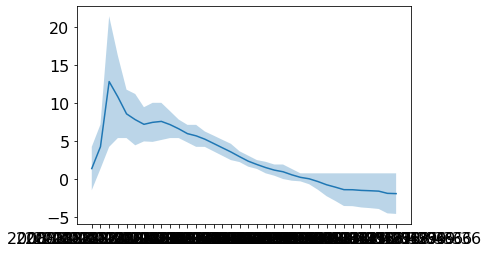

In [10]:
plt.figure()
plt.plot(df30MAS["obs timestamp"], df30MAS["ens estimate time"])
plt.fill_between(df30MAS["obs timestamp"], df30MAS["ens estimate time"]+df30MAS["time uncertainty 1SD"], df30MAS["ens estimate time"]-df30MAS["time uncertainty 1SD"], alpha=0.3)